In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse_score

import mxnet as mx
import mxnet.gluon as gluon

from model import LSTMExogModel
import utils
import train

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
x = np.linspace(-10, 10, 1000)
X = x[:, np.newaxis]
noise = 0.5 * np.random.normal(0, 1, x.shape[0])
y = np.sin(2 * np.pi * x) + noise

start = pd.to_datetime("2018-03-11")
ts_index = pd.DatetimeIndex(start=start, end=start + pd.Timedelta(x.shape[0] - 1, 'd'), freq='1d')
ts = pd.DataFrame(y[:, np.newaxis], columns=['ts'], index=ts_index)

In [211]:
train_ratio = 0.7
split_point = int(ts.shape[0] * train_ratio)
ts_train = ts[:split_point]
ts_test = ts[split_point:]

<IPython.core.display.Javascript object>


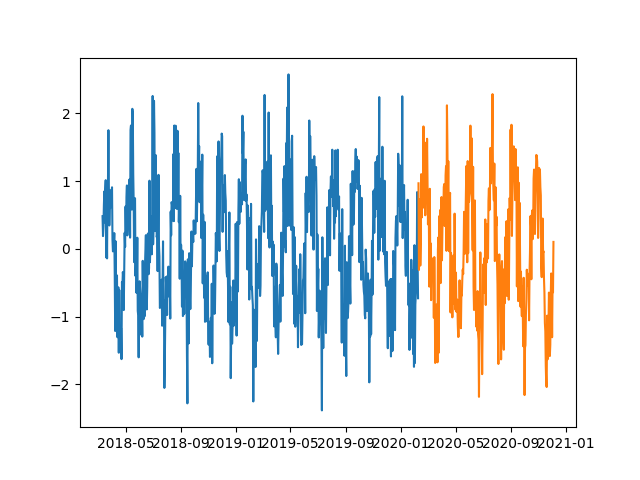

In [212]:
fig, ax = plt.subplots()
ax.plot(ts_train)
ax.plot(ts_test)

<IPython.core.display.Javascript object>


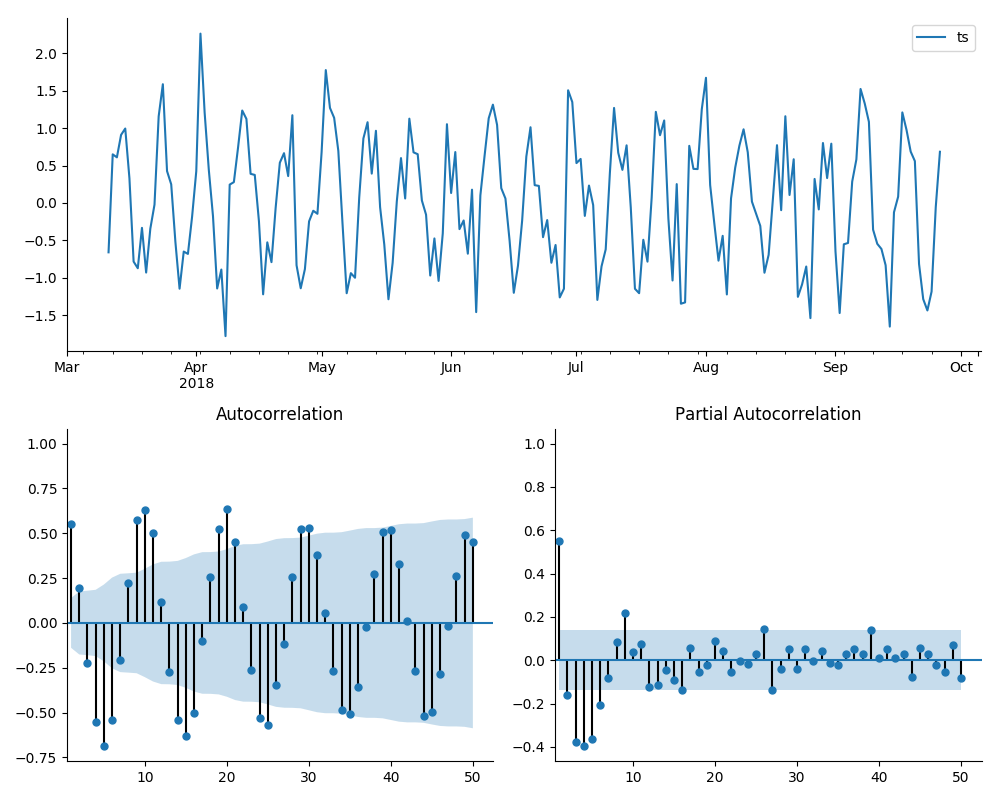

In [86]:
utils.tsplot(ts, lags=50);

We can see from AC plot that points at intervals of 10 days are highly correlated. Our seasonality is about 10. Let's incorrectly specify it, then see how we do predicting.

In [213]:
sarimax = sm.tsa.SARIMAX(ts, order=(0, 0, 0), seasonal_order=(1, 0, 0, 4))
res = sarimax.fit()

<IPython.core.display.Javascript object>


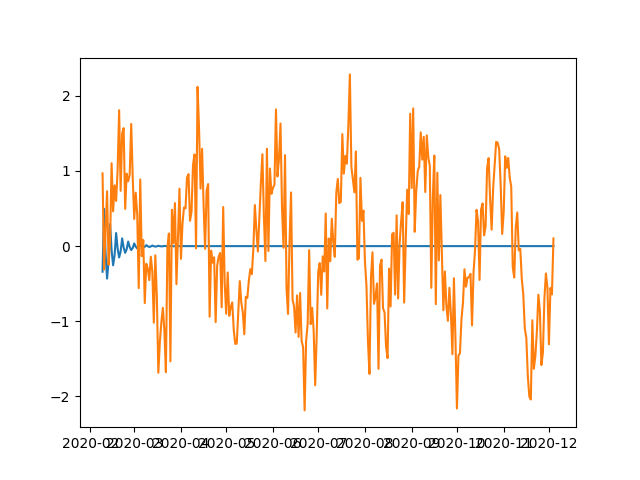

In [214]:
fig, ax = plt.subplots()
preds = res.predict(ts_test.index.min(), ts_test.index.max(), dynamic=True)
ax.plot(preds)
ax.plot(ts_test)

In [193]:
mse_score?

In [215]:
mse_score(ts_test['ts'].values, preds)

0.83420296399308091

Now try correctly specifying seasonality. How many seasonal lags should we include? One should be enough, but because there's a lot of noise, specifying more will help average out the noise.

<IPython.core.display.Javascript object>


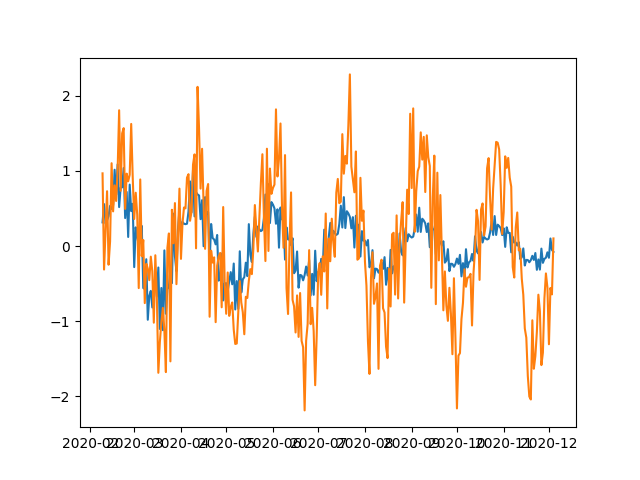

In [217]:
# experiment with seasonal p!
sarimax = sm.tsa.SARIMAX(ts, order=(0, 0, 0), seasonal_order=(5, 0, 0, 10))
res = sarimax.fit()

fig, ax = plt.subplots()
preds = res.predict(ts_test.index.min(), ts_test.index.max(), dynamic=True)
ax.plot(preds)
ax.plot(ts_test)

In [197]:
mse_score(preds, ts_test['ts'].values)

0.72697387103617928

Now let's bust out a simple LSTM and see what we can do.

In [218]:
class SequenceDataset(gluon.data.Dataset):
    
    def __init__(self, endog, in_seq_len, exog=None, out_seq_len=1):
        self.endog = endog
        self.exog = exog
        self.in_seq_len = in_seq_len
        self.out_seq_len = out_seq_len
    
    def __getitem__(self, idx):
        data = self.endog[idx:idx + self.in_seq_len]
        label = self.endog[idx + self.in_seq_len:idx + self.in_seq_len + self.out_seq_len]
        if self.exog is not None:
            exog = self.exog[idx + self.in_seq_len:idx + self.in_seq_len + self.out_seq_len]
        else:
            exog = mx.nd.empty((self.out_seq_len, 1))
        return data, exog, label
    
    def __len__(self):
        return self.endog.shape[0] - self.in_seq_len - self.out_seq_len

In [219]:
# Why oh why do we need this method MXNet??
def detach(hidden):
    if isinstance(hidden, (tuple, list)):
        hidden = [i.detach() for i in hidden]
    else:
        hidden = hidden.detach()
    return hidden

In [220]:
def maybe_print_summary(epoch, log_interval, loss, total_samples, label='train'):
    if (epoch + 1) % log_interval == 0:
        cur_loss = loss / total_samples
        print("[Epoch %d] %s loss = %0.3f" % (epoch + 1, label, cur_loss))

In [244]:
batch_size = 16
input_seq_len = 50  # experiment with this number!!
output_seq_len = 1
num_layers = 1
feature_dim = 1
hidden_size = 32
learning_rate = 0.0001

lstm = LSTMExogModel(hidden_size, num_layers, output_seq_len)

# collect all NDArrays associated with each layer and initialize them
lstm.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(lstm.collect_params(), 'adam', {'learning_rate': learning_rate})

datasets = {'train': SequenceDataset(mx.nd.array(ts_train[['ts']].values), input_seq_len),
            'valid': SequenceDataset(mx.nd.array(ts_test[['ts']].values), input_seq_len)}
loaders = {'train': gluon.data.DataLoader(datasets['train'], batch_size=batch_size, last_batch='discard'),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

train.train_epochs(lstm, loaders, loss, trainer, num_epochs=50, log_interval=10)

[Epoch 10] train loss = 0.590
[Epoch 10] valid loss = 0.567
[Epoch 20] train loss = 0.421
[Epoch 20] valid loss = 0.405
[Epoch 30] train loss = 0.356
[Epoch 30] valid loss = 0.340
[Epoch 40] train loss = 0.320
[Epoch 40] valid loss = 0.306
[Epoch 50] train loss = 0.297
[Epoch 50] valid loss = 0.286


In [247]:
train.train_epochs(lstm, loaders, loss, trainer, num_epochs=50, log_interval=10)

[Epoch 10] train loss = 0.279
[Epoch 10] valid loss = 0.275
[Epoch 20] train loss = 0.265
[Epoch 20] valid loss = 0.268
[Epoch 30] train loss = 0.253
[Epoch 30] valid loss = 0.266
[Epoch 40] train loss = 0.243
[Epoch 40] valid loss = 0.266
[Epoch 50] train loss = 0.235
[Epoch 50] valid loss = 0.268


In [248]:
predict_input = mx.nd.array(ts_train.iloc[-input_seq_len:]['ts'].values).reshape((1, input_seq_len))
predict_input = predict_input.reshape((feature_dim, predict_input.shape[0], predict_input.shape[1]))
outputs = lstm.predict_dynamic(predict_input, ts_test.shape[0], exog_input=None)

<IPython.core.display.Javascript object>


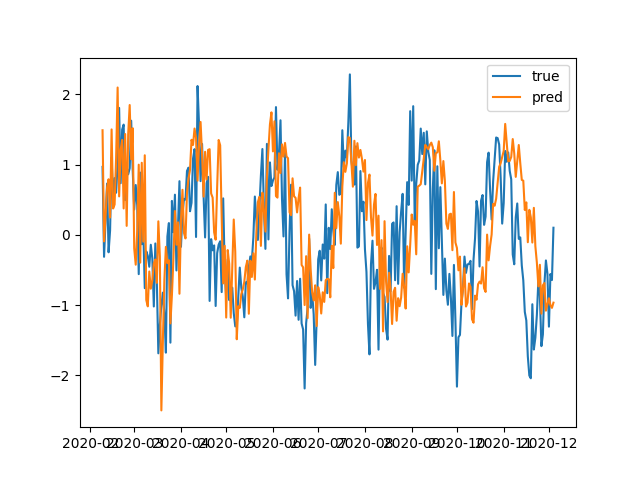

In [249]:
ts_test = ts_test.assign(pred=outputs.asnumpy().ravel())
fig, ax = plt.subplots()
ax.plot(ts_test[['ts']], label='true')
ax.plot(ts_test[['pred']], label='pred')
ax.legend()
# ax.plot(ts.index[ts_train.shape[0]:], np.sin(2 * np.pi * x)[ts_train.shape[0]:])

In [226]:
mse_score(ts_test['pred'].values, ts_test['ts'].values)

0.33087934204029251

## Exogenous

Now we're going to make a signal that changes its level according to some exogenous binary feature. There is no time relation to when this feature is on or off, we're going to make it random. Let's see how we can add exogenous features to our models

In [257]:
n = 2000
x = np.linspace(-50, 50, n)
X = x[:, np.newaxis]
noise = 0.5 * np.random.normal(0, 1, x.shape[0])

idx = np.sort(np.random.choice(np.arange(n), 20, replace=False))
bin_exog = np.zeros(n)
switch = True
for a, b in zip(idx, np.roll(idx, -1)):
    bin_exog[a:b] = int(switch)
    switch = not switch

y = np.sin(2 * np.pi * x) + noise + bin_exog * 5

start = pd.to_datetime("2018-03-11")
ts_index = pd.DatetimeIndex(start=start, end=start + pd.Timedelta(x.shape[0] - 1, 'd'), freq='1d')
ts = pd.DataFrame(y[:, np.newaxis], columns=['ts'], index=ts_index)

In [264]:
train_ratio = 0.7
split_point = int(ts.shape[0] * train_ratio)
ts_train = ts[:split_point]
ts_test = ts[split_point:]
exog_train = bin_exog[:, np.newaxis][:split_point]
exog_test = bin_exog[:, np.newaxis][split_point:]
ts_train = ts_train.assign(exog1=bin_exog[:split_point])
ts_test = ts_test.assign(exog1=bin_exog[split_point:])

<IPython.core.display.Javascript object>


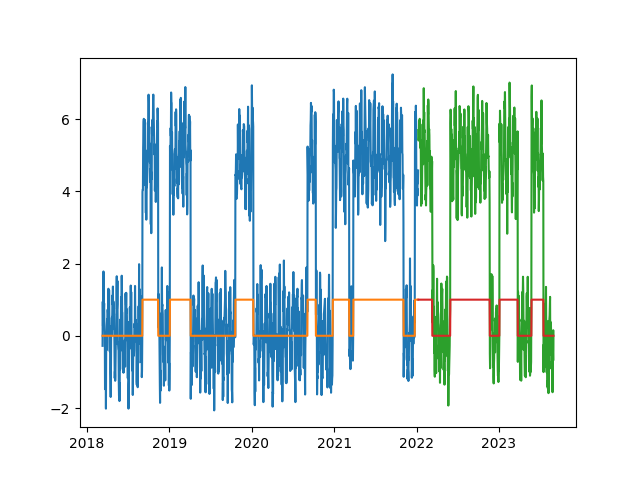

In [265]:
fig, ax = plt.subplots()
ax.plot(ts_train)
ax.plot(ts_test)

<IPython.core.display.Javascript object>


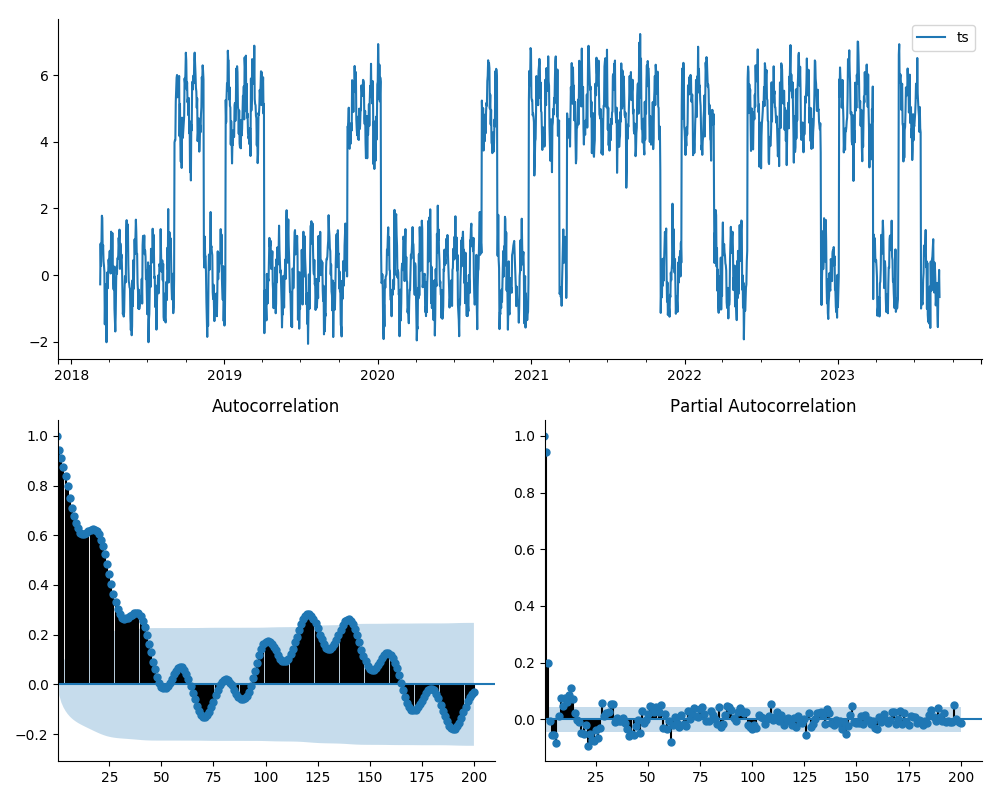

(<matplotlib.axes._subplots.AxesSubplot at 0x1c2f7d5278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2fc038d0>)

In [261]:
utils.tsplot(ts, lags=200)

<IPython.core.display.Javascript object>


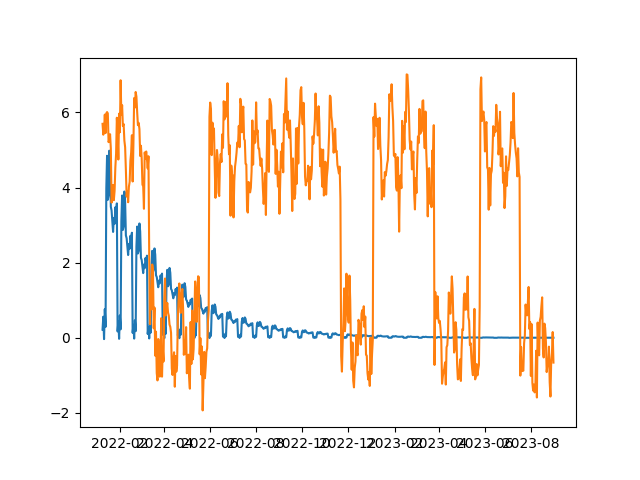

In [262]:
sarimax = sm.tsa.SARIMAX(ts, order=(0, 0, 0), seasonal_order=(1, 0, 0, 20))
res = sarimax.fit()

fig, ax = plt.subplots()
preds = res.predict(ts_test.index.min(), ts_test.index.max(), dynamic=True)
ax.plot(preds)
ax.plot(ts_test)

In [315]:
import train
from model import LSTMExogModel

In [322]:
batch_size = 64
input_seq_len = 60  # experiment with this number!!
output_seq_len = 1
num_layers = 1
feature_dim = 1
hidden_size = 32
learning_rate = 0.0001

lstm = LSTMExogModel(hidden_size, num_layers, output_seq_len)

# collect all NDArrays associated with each layer and initialize them
lstm.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(lstm.collect_params(), 'adam', {'learning_rate': learning_rate})

datasets = {'train': SequenceDataset(mx.nd.array(ts_train[['ts']].values), input_seq_len,
                                    exog=mx.nd.array(ts_train[['exog1']].values)),
            'valid': SequenceDataset(mx.nd.array(ts_test[['ts']].values), input_seq_len,
                                    exog=mx.nd.array(ts_test[['exog1']].values))}
loaders = {'train': gluon.data.DataLoader(datasets['train'], shuffle=True, batch_size=batch_size, last_batch='discard'),
           'valid': gluon.data.DataLoader(datasets['valid'], batch_size=batch_size, last_batch='discard')}

train.train_epochs(lstm, loaders, loss, trainer, num_epochs=50, log_interval=10)

[Epoch 10] train loss = 2.831
[Epoch 10] valid loss = 3.137
[Epoch 20] train loss = 2.345
[Epoch 20] valid loss = 2.300
[Epoch 30] train loss = 2.006
[Epoch 30] valid loss = 2.056
[Epoch 40] train loss = 1.681
[Epoch 40] valid loss = 1.842
[Epoch 50] train loss = 1.409
[Epoch 50] valid loss = 1.492


In [323]:
train.train_epochs(lstm, loaders, loss, trainer, num_epochs=50, log_interval=10)

[Epoch 10] train loss = 1.096
[Epoch 10] valid loss = 1.217
[Epoch 20] train loss = 0.856
[Epoch 20] valid loss = 0.970
[Epoch 30] train loss = 0.629
[Epoch 30] valid loss = 0.766
[Epoch 40] train loss = 0.486
[Epoch 40] valid loss = 0.627
[Epoch 50] train loss = 0.370
[Epoch 50] valid loss = 0.536


In [324]:
predict_input = mx.nd.array(ts_train.iloc[-input_seq_len:]['ts'].values).reshape((1, input_seq_len))
predict_input = predict_input.reshape((feature_dim, predict_input.shape[0], predict_input.shape[1]))
exog_input = mx.nd.array(ts_test[['exog1']].values).reshape((1, 1, ts_test.shape[0]))
outputs = lstm.predict_dynamic(predict_input, ts_test.shape[0], exog_input=exog_input)

<IPython.core.display.Javascript object>


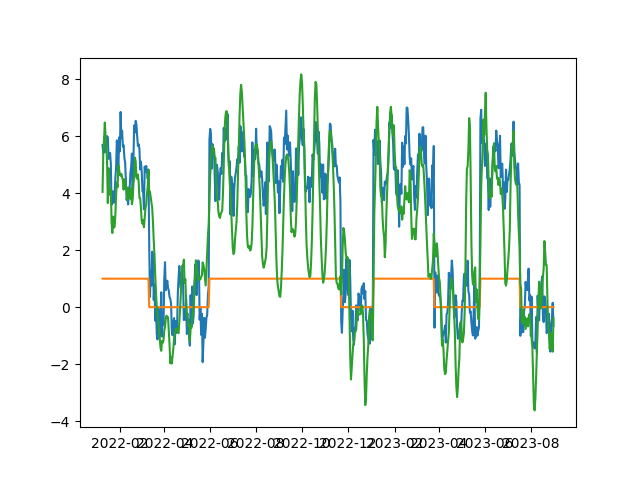

In [325]:
ts_test['pred'] = outputs.asnumpy().ravel()
fig, ax = plt.subplots()
ax.plot(ts_test)
# ax.plot(ts.index[ts_train.shape[0]:], np.sin(2 * np.pi * x)[ts_train.shape[0]:])

<IPython.core.display.Javascript object>


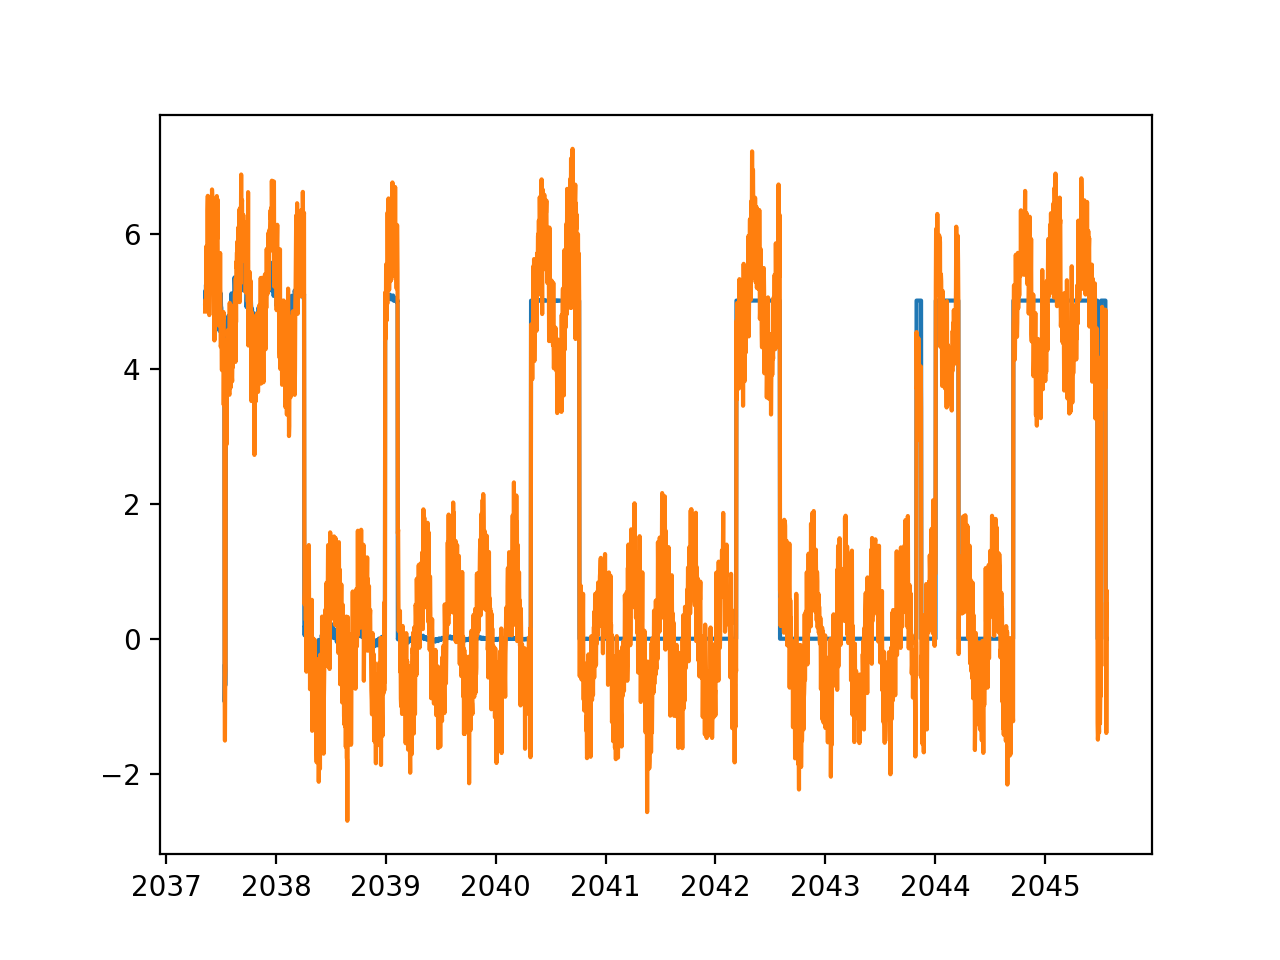

In [243]:
# experiment with the `p` of the seasonal_order
sarimax = sm.tsa.SARIMAX(ts, exog=bin_exog, order=(0, 0, 0), seasonal_order=(5, 0, 0, 10))
res = sarimax.fit()

fig, ax = plt.subplots()
preds = res.predict(ts_test.index.min(), ts_test.index.max(), dynamic=True)
ax.plot(preds)
ax.plot(ts_test[['ts']])

In [361]:
class LSTMExogModel(gluon.Block):
    def __init__(self, hidden_size, input_seq_len, output_seq_len):
        super(LSTMExogModel, self).__init__()
        self.lstm = gluon.rnn.LSTM(hidden_size=hidden_size, num_layers=1)
        self.out = gluon.nn.Dense(output_seq_len, activation=None)
        self.bn1 = gluon.nn.BatchNorm(axis=1)
    
    def forward(self, inputs, hidden, exog=None):
        output, hidden = self.lstm.forward(inputs, hidden)
        output = output.reshape((-1, hidden_size))
        if exog is not None:
#             print(output.shape, exog.shape)
            assert(exog.shape[0] == output.shape[0])
            output = mx.nd.concat(output, exog, dim=1)
        output = self.bn1.forward(output)
        output = self.out.forward(output)
        return output
        
    def begin_state(self, *args, **kwargs):
        return self.lstm.begin_state(*args, **kwargs)

In [275]:
def get_batch_and_exog(batch_size, train, exog, lags, predict_length=1):
    '''
    train: shape (n, -1)
    exog: shape (n, -1)
    '''
    start_points = np.random.randint(0, train.shape[0] - predict_length - lags, batch_size)
    train_slices = []
    labels = []
    exog_slices = []
    for start in start_points:
        train_slices.append(train[start:start + lags])
        exog_slices.append(exog[start + lags, :])
        labels.append(train[start + lags])
    return mx.nd.array(train_slices), mx.nd.array(exog_slices), mx.nd.array(labels)

In [276]:
gluon.nn.BatchNorm?

In [344]:
batch_size = 64
input_seq_len = 200  # experiment with this number!!
output_seq_len = 1
feature_dim = 1
hidden_size = 16
learning_rate = 0.0001

lstm = LSTMExogModel(hidden_size, input_seq_len, output_seq_len)

# collect all NDArrays associated with each layer and initialize them
lstm.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())

trainer = gluon.Trainer(lstm.collect_params(), 'adam', {'learning_rate': learning_rate})
loss = gluon.loss.L2Loss()

In [363]:
num_epochs = 100
batches_per_epoch = 50
log_interval = 2
trainer.set_learning_rate(0.0001)
for epoch in range(num_epochs):
    total_loss = 0.0
    total_samples = 0
    hidden = lstm.begin_state(batch_size=batch_size)
    for i in range(batches_per_epoch):
        data, exog, target = get_batch_and_exog(batch_size, ts_train[['ts']].values, exog_train, input_seq_len)
        assert data.shape == (batch_size, input_seq_len, feature_dim)
        data = data.reshape((feature_dim, batch_size, input_seq_len))
        hidden = detach(hidden)
        with mx.autograd.record():
            output = lstm.forward(data, hidden, exog)
            L = loss(output, target.reshape((batch_size, -1)))
            L.backward()
        trainer.step(batch_size)
        total_loss += mx.nd.sum(L).asscalar()
        total_samples += target.shape[0]
    # Print test loss
    data, exog, target = get_batch_and_exog(batch_size, ts_test[['ts']].values, exog_test, input_seq_len)
    data = data.reshape((feature_dim, batch_size, input_seq_len))
    hidden = detach(hidden)
    output = lstm.forward(data, hidden, exog)
    test_loss = loss(output, target.reshape((batch_size, -1)))
    maybe_print_summary(epoch, log_interval, mx.nd.sum(test_loss).asscalar(), target.shape[0], label='test')
    
    maybe_print_summary(epoch, log_interval, total_loss, total_samples)

[Epoch 2] test loss = 0.269
[Epoch 2] train loss = 0.238
[Epoch 4] test loss = 0.480
[Epoch 4] train loss = 0.232
[Epoch 6] test loss = 0.245
[Epoch 6] train loss = 0.191
[Epoch 8] test loss = 0.221
[Epoch 8] train loss = 0.219
[Epoch 10] test loss = 0.381
[Epoch 10] train loss = 0.235
[Epoch 12] test loss = 0.265
[Epoch 12] train loss = 0.210
[Epoch 14] test loss = 0.344
[Epoch 14] train loss = 0.205
[Epoch 16] test loss = 0.340
[Epoch 16] train loss = 0.211
[Epoch 18] test loss = 0.278
[Epoch 18] train loss = 0.202
[Epoch 20] test loss = 0.237
[Epoch 20] train loss = 0.195
[Epoch 22] test loss = 0.199
[Epoch 22] train loss = 0.208
[Epoch 24] test loss = 0.199
[Epoch 24] train loss = 0.209
[Epoch 26] test loss = 0.249
[Epoch 26] train loss = 0.220
[Epoch 28] test loss = 0.167
[Epoch 28] train loss = 0.222
[Epoch 30] test loss = 0.218
[Epoch 30] train loss = 0.227
[Epoch 32] test loss = 0.339
[Epoch 32] train loss = 0.216
[Epoch 34] test loss = 0.274
[Epoch 34] train loss = 0.212
[Epoc

In [346]:
def predict_dynamic_exog(predict_input, exog, output_seq_len):
    '''
    Here we need to repeatedly append the predictions to the input sequence and 
    keep on predicting.
    y1 = predict([x0, x1, x2])
    y2 = predict([x1, x2, y1])
    ...
    yn = predict([yn-3, yn-2, yn-1])
    '''

    feature_dim, pred_batch_size, input_seq_len = predict_input.shape
    exog_dim = exog.shape[2]
    assert exog.shape == (output_seq_len, pred_batch_size, exog_dim)
    
    # this buffer holds the input and output as we fill things in
    inp_buffer = mx.nd.zeros((feature_dim, pred_batch_size, input_seq_len + output_seq_len))
    inp_buffer[:, :, :input_seq_len] = predict_input[:, 0, :]

    inp = inp_buffer[:, :, :input_seq_len]
    hidden = lstm.begin_state(batch_size=pred_batch_size)
    for j in range(output_seq_len):
        output = lstm.forward(inp, hidden, exog[j, :, :].reshape((pred_batch_size, exog_dim)))
#         print(exog[j, :, :].reshape((pred_batch_size, exog_dim)))
        assert output.shape == (pred_batch_size, lstm.out.weight.shape[0])
        inp_buffer[0, :, input_seq_len + j:input_seq_len + j + 1] = output
        inp = inp_buffer[:, :, j + 1:input_seq_len + j + 1]
    return inp_buffer[:, :, input_seq_len:]

In [347]:
def get_batch_date(df, seq_len, idxs, cols=None):
    seqs = []
    if cols is None:
        cols = df.columns
    for idx in idxs:
        seqs.append(df[cols].iloc[idx:idx + seq_len].values)
    return np.array(seqs)

In [25]:
ts_train = ts_train.assign(exog1=exog_train.ravel())
ts_test = ts_test.assign(exog1=exog_test.ravel());

NameError: name 'exog_train' is not defined

In [351]:
idx = 50
predict_input_np = get_batch_date(ts_train, input_seq_len, [idx], cols=['ts']).transpose(2, 0, 1)
predict_input = mx.nd.array(predict_input_np)
predict_output_length = ts_test.shape[0]
predict_exog_np = get_batch_date(ts_train, predict_output_length, [idx + input_seq_len], cols=['exog1']).transpose(1, 0, 2)
predict_exog = mx.nd.array(predict_exog_np)
pred_batch_size = predict_input.shape[1]
test_exog = mx.nd.array(bin_exog[ts_train.shape[0]:][:, np.newaxis])
outputs = predict_dynamic_exog(predict_input, predict_exog, ts_test.shape[0])

In [352]:
assert (feature_dim, pred_batch_size, ts_test.shape[0]) == outputs.shape

<IPython.core.display.Javascript object>


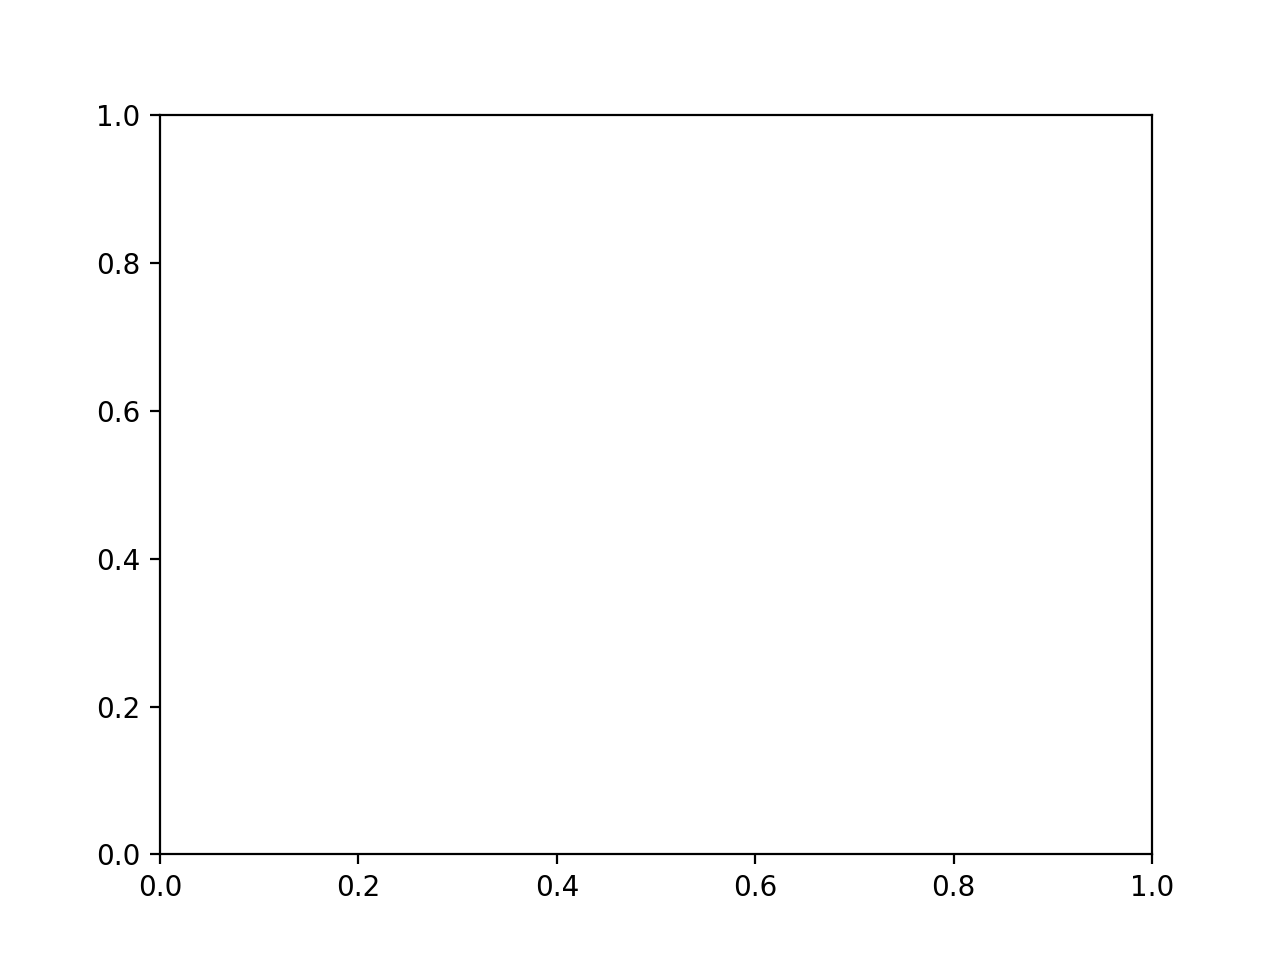

NameError: name 'idx' is not defined

In [24]:
batch_index = 0
fig, ax = plt.subplots()
start = idx
stop = idx + input_seq_len + predict_output_length
ax.plot(ts_train.index[start:stop], ts_train['ts'].iloc[start:stop])
ax.plot(ts_train.index[start:stop], ts_train['exog1'].iloc[start:stop])
ax.plot(ts_train.index[start + input_seq_len:stop], outputs[0, batch_index, :].asnumpy())

In [354]:
idx = ts_train.shape[0] - input_seq_len
predict_input_np = get_batch_date(ts_train, input_seq_len, [idx], cols=['ts']).transpose(2, 0, 1)
predict_input = mx.nd.array(predict_input_np)
predict_output_length = ts_test.shape[0]
predict_exog_np = get_batch_date(ts_test, predict_output_length, [0], cols=['exog1']).transpose(1, 0, 2)
predict_exog = mx.nd.array(predict_exog_np)
pred_batch_size = predict_input.shape[1]
test_exog = mx.nd.array(bin_exog[ts_train.shape[0]:][:, np.newaxis])
outputs = predict_dynamic_exog(predict_input, predict_exog, ts_test.shape[0])

<IPython.core.display.Javascript object>


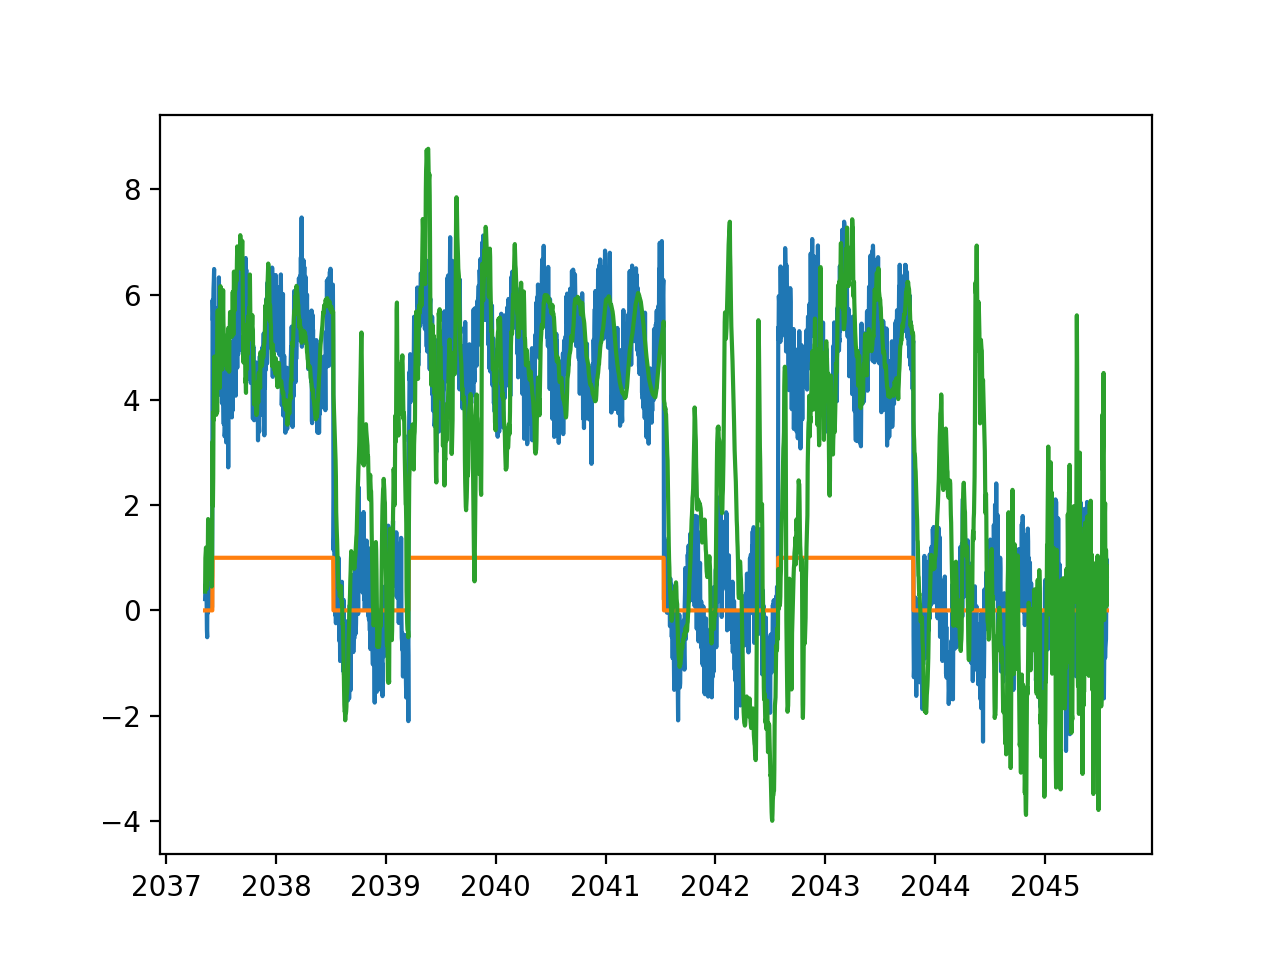

In [356]:
batch_index = 0
fig, ax = plt.subplots()
start = idx
stop = idx + input_seq_len + predict_output_length
ax.plot(ts_test.index, ts_test['ts'])
ax.plot(ts_test.index, ts_test['exog1'])
ax.plot(ts_test.index, outputs[0, batch_index, :].asnumpy())